# AdaHessian with Native Fastai Optimizer
- With Imagenette and ImageWoof

In [1]:
from fastai.vision.all import *
from fastai.callback.all import *

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
def get_dls(size=128):
    dls = ImageDataLoaders.from_folder(path, valid='val', 
        item_tfms=[RandomResizedCrop(size, min_scale=0.35),FlipItem(p=0.5)],  # Resize(size)
        batch_tfms=Normalize.from_stats(*imagenet_stats)) 
    return dls

dls = get_dls(size=128)

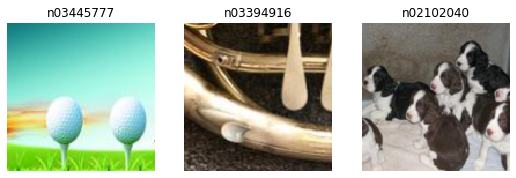

In [4]:
dls.show_batch(max_n=3)

## AdaHessian

@article{yao2020adahessian,
  title={ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning},
  author={Yao, Zhewei and Gholami, Amir and Shen, Sheng and Keutzer, Kurt and Mahoney, Michael W},
  journal={arXiv preprint arXiv:2006.00719},
  year={2020}
}

In [5]:
def average_sqr_diag_hessian(p, sqr_mom, dampening=True, sqr_avg_diag_hessian=None, hutchinson_trace=None, **kwargs):
    if sqr_avg_diag_hessian is None: sqr_avg_diag_hessian = torch.zeros_like(p.grad.data)
    damp = 1-sqr_mom if dampening else 1.
    sqr_avg_diag_hessian.mul_(sqr_mom).addcmul_(hutchinson_trace, hutchinson_trace, value=damp)
    return {'sqr_avg_diag_hessian': sqr_avg_diag_hessian}

In [6]:
def adahessian_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg_diag_hessian, hessian_power, eps, **kwargs):
    "Step for Adam with `lr` on `p`"
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    if hessian_power < 1:
        p.data.addcdiv_(grad_avg, ((sqr_avg_diag_hessian/debias2).sqrt() ** hessian_power) + eps, value = -lr / debias1)  
    else:
        p.data.addcdiv_(grad_avg, (sqr_avg_diag_hessian/debias2).sqrt() + eps, value = -lr / debias1)    
    return p

In [7]:
@log_args(to_return=True, but_as=Optimizer.__init__)
def AdaHessian(params, lr=0.1, hessian_power=1., hutchinson_trace=None, mom=0.9, sqr_mom=0.98, eps=1e-4, wd=1e-4, decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`, sqr_mom=0.999 for image classification"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_diag_hessian, step_stat, adahessian_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, hessian_power=hessian_power, eps=eps, wd=wd)


In [21]:
class HutchinsonTraceCallback(Callback):
    run_before=MixedPrecision
    
    def __init__(self, block_length=1, clip=None):
        self.block_length = block_length
        
    def _get_params_grad(self):
        params, gradsH = [], []
        for p,*_ in self.opt.all_params(with_grad=True):
            params.append(p)
            gradsH.append(0. if p.grad is None else p.grad + 0.)
        return params, gradsH
    
    def after_backward(self): 
        # Gather Parmams + Gradients
        params, gradsH = self._get_params_grad()
         
        # Create random vector
        v = [torch.randint_like(p, high=2, device=self.dls.device) for p in params]
        for v_i in v: v_i[v_i == 0] = -1

        # Perform 2nd differentiation
        hvs = torch.autograd.grad(gradsH, params, grad_outputs=v, only_inputs=True, retain_graph=False)

        hutchinson_trace = []
        for hv, vi in zip(hvs, v):
            param_size = hv.size()

            if len(param_size) <= 1:  
                # For 1D tensor, e.g.,, bias, BatchNorm, LayerNorm etc.
                # Usually, you do not need to set spatial aveging for it, i.e., Hessian diagonal block size is 1 here.
                tmp_output = torch.abs(hv * vi)
                hutchinson_trace.append(tmp_output)

                # Of course, you can also use the same way as 2D tensor does to average your 1D tensor. 
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 2: 
                # For 2D tensor, e.g., the matrix in the fully-connected layer.
                # This is a normal case for MLP, Transformer models. 
                # Usually, a spatial averaging needs to be used here to get the best result.
                # If you are not looking for the absolute best config, you may set it to be 1.
                # In all of our experiments, we sill get pretty good performance.
                tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                hutchinson_trace.append(tmp_output3)
            elif len(param_size) == 3:
                # For 3D tensor, e.g., the 1D Conv layer.
                # This layer is usually used for Char-LM.

                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 20 and your kernel size is 5, 
                # then the 1D Conv kernel is in size 20x20x5, you can average along the final dim, i.e., the block_length = 5
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2], keepdim=True)) / vi[0, 1].numel() # torch.sum() reduces the dim 2， i.e. the size 5

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 3D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 4:  
                # For 4D tensor, e.g, the 2D Conv layer
                # This layer is usually used for CV tasks.

                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 256 and your kernel size is 3x3, 
                # then the 2D Conv kernel is in size 20x20x3x3, you can average along the last two dims, , i.e., the block_length = 9
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2, 3], keepdim=True)) / vi[0, 1].numel() # torch.sum() reduces the dim 2/3.
                hutchinson_trace.append(tmp_output)

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 4D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)
        
        # Add hutchinson trace to optimizer state
        for i, (_,_,state,_) in enumerate(self.learn.opt.all_params(with_grad=True)):
            state['hutchinson_trace'] = hutchinson_trace[i]

In [22]:
@patch
def _backward(self:Learner): self.loss.backward(create_graph=True)    # <---- Changed this

In [23]:
def get_learn(opt=AdaHessian):
    cbs = HutchinsonTraceCallback(block_length=32)
    learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, 
                        loss_func=LabelSmoothingCrossEntropy(), cbs=cbs)
    return learn

In [24]:
def run_learn(runs=1, epochs=5, lr=1e-3, opt=AdaHessian):
    acc_ls=[]
    for i in range(runs):
        print(f'Run {i}')
        learn = get_learn(opt=opt)
        learn.fit_one_cycle(epochs, lr)
        acc_ls.append(learn.final_record[2])
    print(f'Mean accuracy for {runs} runs: {np.mean(acc_ls)} ±{np.std(acc_ls)}')

In [25]:
opt = AdaHessian
cbs = HutchinsonTraceCallback(block_length=32)

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=7.585775847473997e-07)

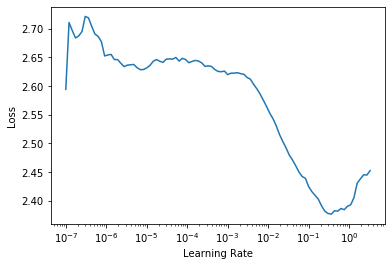

In [26]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, 
                        loss_func=LabelSmoothingCrossEntropy(), cbs=cbs)
learn.lr_find()

In [27]:
learn.fit_one_cycle(1, 15e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.594861,1.456475,0.609427,00:52


### 5e Native

In [13]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=AdaHessian)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.729688,2.602908,0.341146,00:52
1,1.517886,1.860322,0.507516,00:51
2,1.322673,1.488588,0.603567,00:51
3,1.151138,1.082368,0.769427,00:51
4,1.014084,0.988459,0.807643,00:52


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.721501,2.332257,0.393885,00:52
1,1.510266,1.860780,0.497325,00:52
2,1.339560,1.488912,0.585478,00:52
3,1.139338,1.121245,0.744713,00:52
4,1.018626,0.991746,0.803312,00:52


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.719649,1.993442,0.453758,00:52
1,1.513269,2.254652,0.425478,00:52
2,1.337855,1.427599,0.618344,00:52
3,1.149212,1.095926,0.752357,00:52
4,1.022344,0.998910,0.797707,00:52


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.743636,1.762092,0.472866,00:52
1,1.535395,1.586698,0.547006,00:52
2,1.351815,1.716219,0.472611,00:52
3,1.154768,1.146298,0.731720,00:52
4,1.025152,1.007474,0.796943,00:52


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.760884,2.387745,0.352866,00:52
1,1.512994,1.995087,0.442293,00:52
2,1.339789,1.269990,0.684586,00:52
3,1.134529,1.174119,0.721783,00:52
4,1.015226,0.998726,0.801783,00:52


Mean accuracy for 5 runs: 0.8014777064323425 ±0.0039053251942751228
